In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.metrics import mean_squared_error
import matplotlib.pyplot as plt

# prepare the data

In [ ]:
# Load the dataset
data = pd.read_csv('weather_prediction_dataset.csv')

In [ ]:
# print data
data

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,20091229,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,20091230,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,20091231,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9


In [ ]:
# select features
features = ['DATE', 'TOURS_temp_max', 'TOURS_temp_min', 'TOURS_temp_mean','TOURS_global_radiation']
data = data[features]

In [ ]:
# # converting the 'DATE' column in the DataFrame 'data' to datetime format
# data.loc[:, 'DATE'] = pd.to_datetime(data.loc[:, 'DATE'])

In [ ]:
# print data
data

,DATE,TOURS_temp_max,TOURS_temp_min,TOURS_temp_mean,TOURS_global_radiation
0,20000101,9.8,7.2,8.5,0.25
1,20000102,9.2,6.6,7.9,0.17
2,20000103,9.6,6.6,8.1,0.27
3,20000104,10.8,6.4,8.6,0.11
4,20000105,9.5,6.4,8.0,0.39
...,...,...,...,...,...
3649,20091228,10.6,1.8,6.2,0.22
3650,20091229,14.5,6.2,10.4,0.24
3651,20091230,11.3,8.7,10.0,0.24
3652,20091231,10.9,6.2,8.5,0.58


In [ ]:
# divide the data

# Dates from 2000 to 2007 used for training your model
train_set = data[(data['DATE'] >= 20000101) & (data['DATE'] < 20080101)]

# Dates from 2008 and 2009 used to validate your model
val_set = data[(data['DATE'] >= 20080101) & (data['DATE'] < 20100101)]

In [ ]:
# Define the features and target variables
features = ['TOURS_temp_min', 'TOURS_temp_mean','TOURS_global_radiation']
target = 'TOURS_temp_max'

# Extract the features and target values from the training set
X_train = train_set[features].values
y_train = train_set[target].values

# Extract the features and target values from the validation set
X_val = val_set[features].values
y_val = val_set[target].values

In [ ]:
print(f'''X_train shape : {X_train.shape}
y_train shape : {y_train.shape}
X_val shape : {X_val.shape}
y_val shape : {y_val.shape}''')

X_train shape : (2922, 3)
y_train shape : (2922,)
X_val shape : (731, 3)
y_val shape : (731,)


In [ ]:
# applay 3 timesteps using slaid window on featurs data
# Define different time steps for creating input sequences
timesteps = [1, 25, 90]

# Create input sequences with the first time step
X_train_1 = np.zeros((X_train.shape[0] - timesteps[0] + 1, timesteps[0], X_train.shape[1]))
for i in range(timesteps[0]):
  X_train_1[:, i, :] = X_train[i:X_train.shape[0] - timesteps[0] + i + 1, :]

X_val_1 = np.zeros((X_val.shape[0] - timesteps[0] + 1, timesteps[0], X_val.shape[1]))
for i in range(timesteps[0]):
  X_val_1[:, i, :] = X_val[i:X_val.shape[0] - timesteps[0] + i + 1, :]

# Create input sequences with the second time step
X_train_2 = np.zeros((X_train.shape[0] - timesteps[1] + 1, timesteps[1], X_train.shape[1]))
for i in range(timesteps[1]):
  X_train_2[:, i, :] = X_train[i:X_train.shape[0] - timesteps[1] + i + 1, :]

X_val_2 = np.zeros((X_val.shape[0] - timesteps[1] + 1, timesteps[1], X_val.shape[1]))
for i in range(timesteps[1]):
  X_val_2[:, i, :] = X_val[i:X_val.shape[0] - timesteps[1] + i + 1, :]

# Create input sequences with the third time step
X_train_3 = np.zeros((X_train.shape[0] - timesteps[2] + 1, timesteps[2], X_train.shape[1]))
for i in range(timesteps[2]):
  X_train_3[:, i, :] = X_train[i:X_train.shape[0] - timesteps[2] + i + 1, :]

X_val_3 = np.zeros((X_val.shape[0] - timesteps[2] + 1, timesteps[2], X_val.shape[1]))
for i in range(timesteps[2]):
  X_val_3[:, i, :] = X_val[i:X_val.shape[0] - timesteps[2] + i + 1, :]


In [ ]:
# applay 3 timesteps using slaid window on labels data

# Create input sequences with the first time step
y_train_1 = y_train[timesteps[0] - 1:]
y_val_1 = y_val[timesteps[0] - 1:]

# Create input sequences with the second time step
y_train_2 = y_train[timesteps[1] - 1:]
y_val_2 = y_val[timesteps[1] - 1:]

# Create input sequences with the third time step
y_train_3 = y_train[timesteps[2] - 1:]
y_val_3 = y_val[timesteps[2] - 1:]

In [ ]:
# Train each model with early stopping
es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1,restore_best_weights=True)

# RNN Models

In [ ]:
# first model
rnn_model_1 = Sequential()

# add layers
rnn_model_1.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_1.shape[1],X_train_1.shape[2])))
rnn_model_1.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
rnn_model_1.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
rnn_history_1 = rnn_model_1.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
92/92 [==============================] - 1s 6ms/step - loss: 260.0257 - val_loss: 182.4758
Epoch 2/500
92/92 [==============================] - 0s 4ms/step - loss: 141.7522 - val_loss: 102.3152
Epoch 3/500
92/92 [==============================] - 0s 4ms/step - loss: 92.7796 - val_loss: 72.1819
Epoch 4/500
92/92 [==============================] - 0s 4ms/step - loss: 67.8235 - val_loss: 52.8593
Epoch 5/500
92/92 [==============================] - 0s 4ms/step - loss: 51.4976 - val_loss: 40.0061
Epoch 6/500
92/92 [==============================] - 0s 4ms/step - loss: 39.7917 - val_loss: 30.4135
Epoch 7/500
92/92 [==============================] - 0s 4ms/step - loss: 31.1086 - val_loss: 23.4853
Epoch 8/500
92/92 [==============================] - 0s 4ms/step - loss: 24.6513 - val_loss: 18.3561
Epoch 9/500
92/92 [==============================] - 0s 4ms/step - loss: 19.8655 - val_loss: 14.6309
Epoch 10/500
92/92 [==============================] - 0s 4ms/step - loss: 16.3539 - val

In [ ]:
# predict validtion data
y_hat = rnn_model_1.predict(X_val_1)
y_hat.shape

23/23 [==============================] - 0s 3ms/step


(731, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_rnn_1 = mean_squared_error(y_val_1, y_hat).numpy()
mse_rnn_1

0.005647773

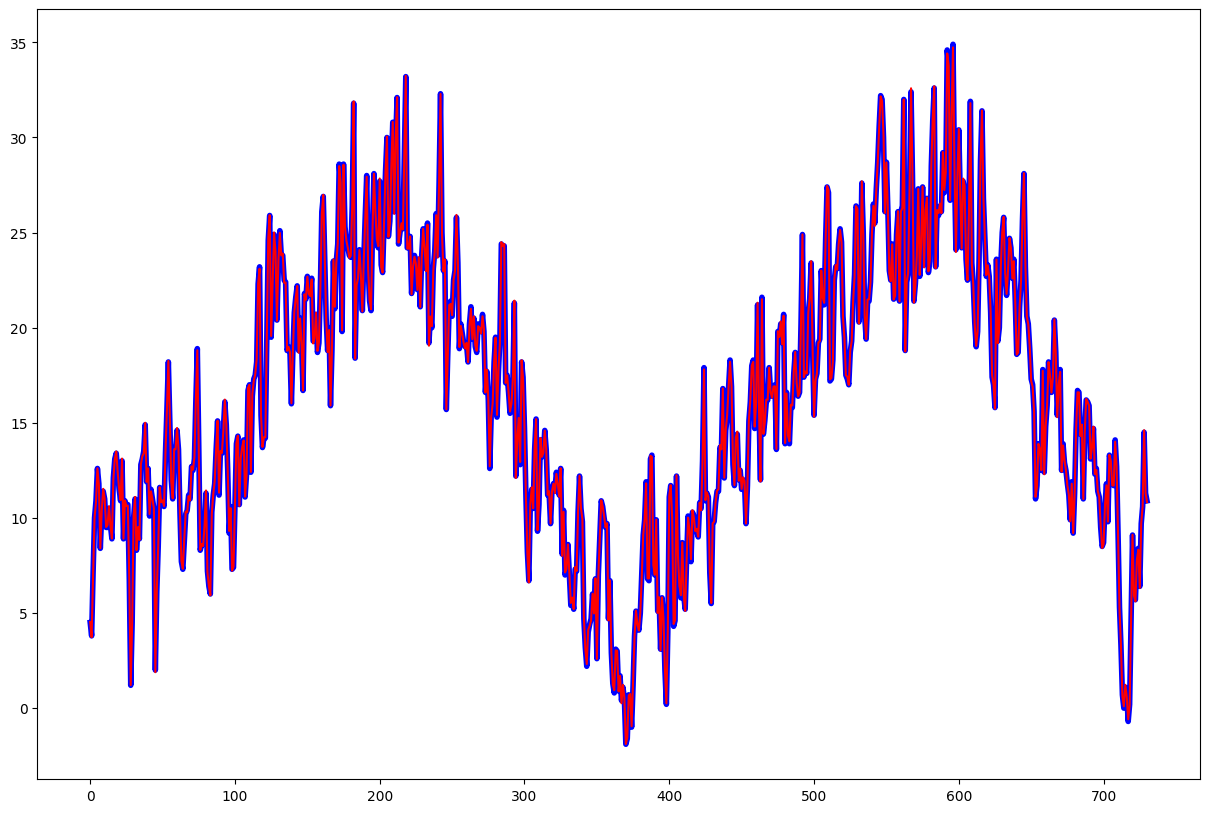

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_1, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [ ]:
# second model
rnn_model_2 = Sequential()

# add layers
rnn_model_2.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_2.shape[1],X_train_2.shape[2])))
rnn_model_2.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
rnn_model_2.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
rnn_history_2 = rnn_model_2.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
91/91 [==============================] - 3s 20ms/step - loss: 233.6871 - val_loss: 143.4397
Epoch 2/500
91/91 [==============================] - 2s 19ms/step - loss: 120.3797 - val_loss: 94.9825
Epoch 3/500
91/91 [==============================] - 2s 18ms/step - loss: 84.5683 - val_loss: 66.6338
Epoch 4/500
91/91 [==============================] - 2s 18ms/step - loss: 61.0483 - val_loss: 47.5436
Epoch 5/500
91/91 [==============================] - 2s 18ms/step - loss: 44.5228 - val_loss: 34.1665
Epoch 6/500
91/91 [==============================] - 2s 18ms/step - loss: 32.7654 - val_loss: 24.6663
Epoch 7/500
91/91 [==============================] - 3s 31ms/step - loss: 24.4490 - val_loss: 18.0605
Epoch 8/500
91/91 [==============================] - 2s 18ms/step - loss: 18.5961 - val_loss: 13.3259
Epoch 9/500
91/91 [==============================] - 2s 18ms/step - loss: 14.4096 - val_loss: 10.0196
Epoch 10/500
91/91 [==============================] - 2s 17ms/step - loss: 11.3

In [ ]:
# predict validtion data
y_hat = rnn_model_2.predict(X_val_2)
y_hat.shape

23/23 [==============================] - 0s 6ms/step


(707, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_rnn_2 = mean_squared_error(y_val_2, y_hat).numpy()
mse_rnn_2

0.0077717067

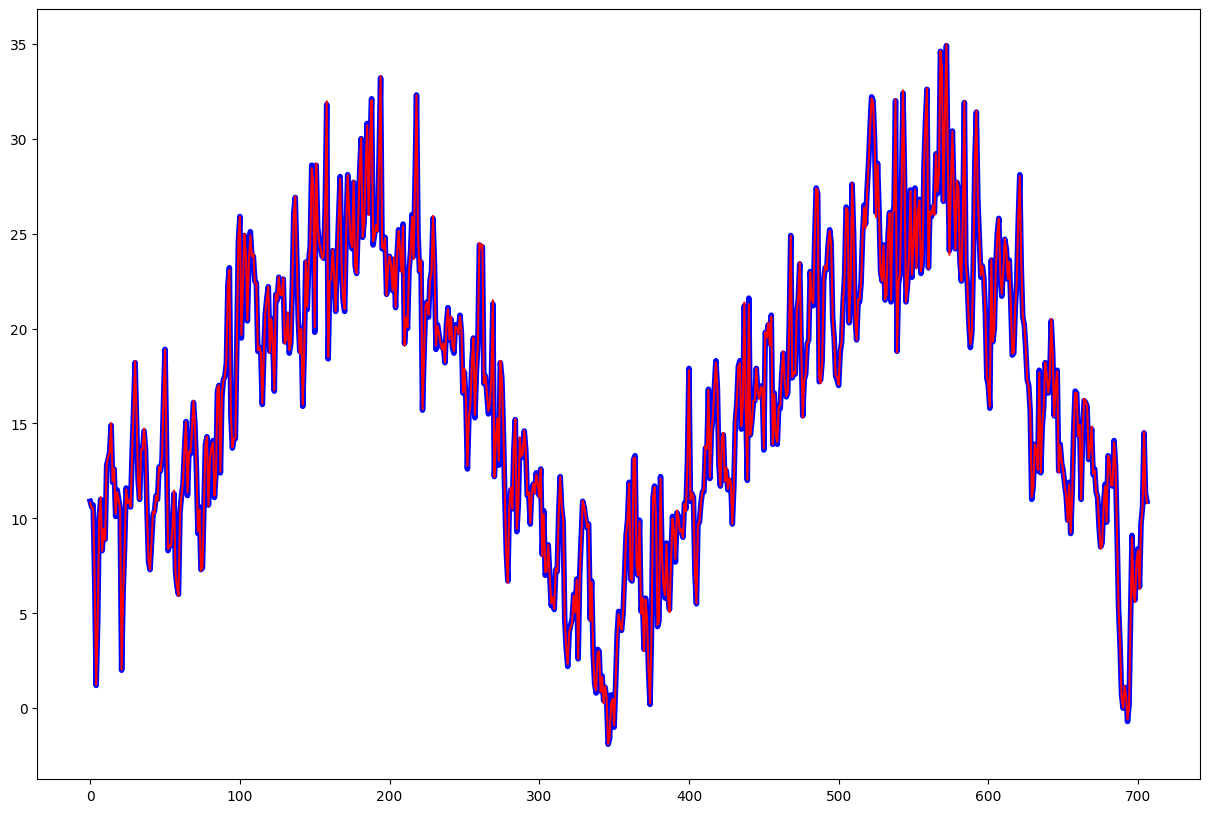

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_2, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [ ]:
# third model
rnn_model_3 = Sequential()

# add layers
rnn_model_3.add(SimpleRNN(units=32, activation='tanh', input_shape=(X_train_3.shape[1],X_train_3.shape[2])))
rnn_model_3.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
rnn_model_3.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
rnn_history_3 = rnn_model_3.fit(X_train_3, y_train_3, validation_data=(X_val_3, y_val_3), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
89/89 [==============================] - 7s 62ms/step - loss: 264.8361 - val_loss: 212.5191
Epoch 2/500
89/89 [==============================] - 5s 58ms/step - loss: 164.3809 - val_loss: 136.5933
Epoch 3/500
89/89 [==============================] - 6s 69ms/step - loss: 113.4334 - val_loss: 97.9636
Epoch 4/500
89/89 [==============================] - 5s 56ms/step - loss: 83.0209 - val_loss: 71.3097
Epoch 5/500
89/89 [==============================] - 6s 70ms/step - loss: 61.5388 - val_loss: 52.1094
Epoch 6/500
89/89 [==============================] - 5s 56ms/step - loss: 45.9878 - val_loss: 38.4535
Epoch 7/500
89/89 [==============================] - 6s 70ms/step - loss: 34.7156 - val_loss: 28.4539
Epoch 8/500
89/89 [==============================] - 5s 57ms/step - loss: 26.5519 - val_loss: 21.3656
Epoch 9/500
89/89 [==============================] - 6s 69ms/step - loss: 20.5965 - val_loss: 16.2857
Epoch 10/500
89/89 [==============================] - 5s 57ms/step - loss: 16

In [ ]:
# predict validtion data
y_hat = rnn_model_3.predict(X_val_3)
y_hat.shape

21/21 [==============================] - 0s 9ms/step


(642, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_rnn_3 = mean_squared_error(y_val_3, y_hat).numpy()
mse_rnn_3

0.007519107

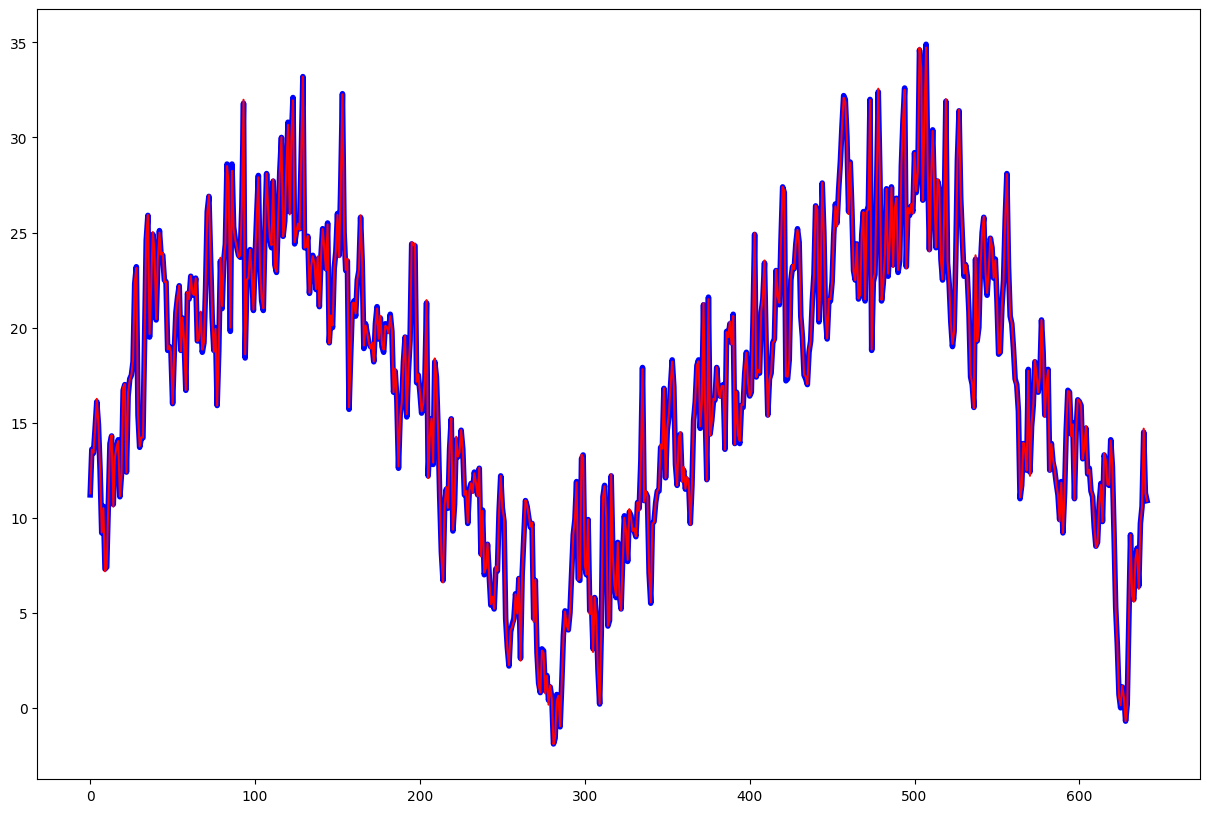

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_3, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

# LSTM Models

In [ ]:
# first model
lstm_model_1 = Sequential()

#compile the model
lstm_model_1.add(LSTM(units=32, activation='tanh', input_shape=(X_train_1.shape[1],X_train_1.shape[2])))
lstm_model_1.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model_1.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
lstm_history_1 = lstm_model_1.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
92/92 [==============================] - 3s 9ms/step - loss: 285.6542 - val_loss: 227.7501
Epoch 2/500
92/92 [==============================] - 0s 5ms/step - loss: 193.9283 - val_loss: 146.1292
Epoch 3/500
92/92 [==============================] - 0s 4ms/step - loss: 120.5849 - val_loss: 86.9457
Epoch 4/500
92/92 [==============================] - 0s 5ms/step - loss: 76.5338 - val_loss: 58.1009
Epoch 5/500
92/92 [==============================] - 0s 4ms/step - loss: 55.4982 - val_loss: 43.2439
Epoch 6/500
92/92 [==============================] - 0s 5ms/step - loss: 42.6826 - val_loss: 32.6745
Epoch 7/500
92/92 [==============================] - 0s 5ms/step - loss: 33.1817 - val_loss: 25.2811
Epoch 8/500
92/92 [==============================] - 0s 5ms/step - loss: 26.3260 - val_loss: 19.7702
Epoch 9/500
92/92 [==============================] - 0s 5ms/step - loss: 21.2154 - val_loss: 15.7084
Epoch 10/500
92/92 [==============================] - 0s 4ms/step - loss: 17.2654 - va

In [ ]:
# predict validtion data
y_hat = lstm_model_1.predict(X_val_1)
y_hat.shape

23/23 [==============================] - 1s 3ms/step


(731, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_lstm_1 = mean_squared_error(y_val_1, y_hat).numpy()
mse_lstm_1

0.0058883624

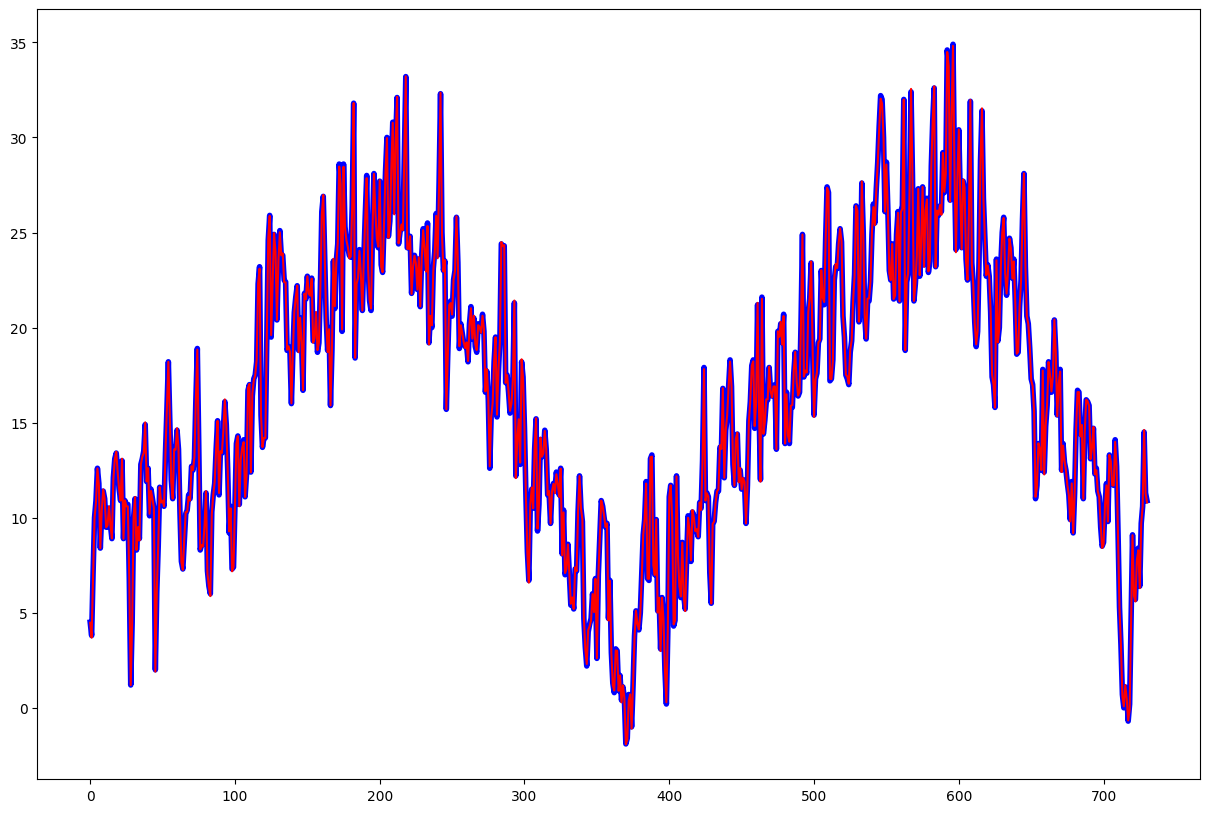

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_1, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [ ]:
# second model
lstm_model_2 = Sequential()

#compile the model
lstm_model_2.add(LSTM(units=32, activation='tanh', input_shape=(X_train_2.shape[1],X_train_2.shape[2])))
lstm_model_2.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model_2.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
lstm_history_2 = lstm_model_2.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
91/91 [==============================] - 3s 11ms/step - loss: 225.5964 - val_loss: 146.8987
Epoch 2/500
91/91 [==============================] - 0s 5ms/step - loss: 112.3873 - val_loss: 83.1170
Epoch 3/500
91/91 [==============================] - 0s 5ms/step - loss: 73.9877 - val_loss: 57.2980
Epoch 4/500
91/91 [==============================] - 0s 5ms/step - loss: 51.4464 - val_loss: 38.3167
Epoch 5/500
91/91 [==============================] - 0s 5ms/step - loss: 35.7099 - val_loss: 26.3157
Epoch 6/500
91/91 [==============================] - 0s 5ms/step - loss: 25.8077 - val_loss: 18.7575
Epoch 7/500
91/91 [==============================] - 0s 5ms/step - loss: 19.2124 - val_loss: 13.6391
Epoch 8/500
91/91 [==============================] - 0s 5ms/step - loss: 14.6755 - val_loss: 10.1522
Epoch 9/500
91/91 [==============================] - 0s 5ms/step - loss: 11.5042 - val_loss: 7.7789
Epoch 10/500
91/91 [==============================] - 0s 5ms/step - loss: 9.1746 - val_l

In [ ]:
# predict validtion data
y_hat = lstm_model_2.predict(X_val_2)
y_hat.shape

23/23 [==============================] - 0s 2ms/step


(707, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_lstm_2 = mean_squared_error(y_val_2, y_hat).numpy()
mse_lstm_2

0.0077394955

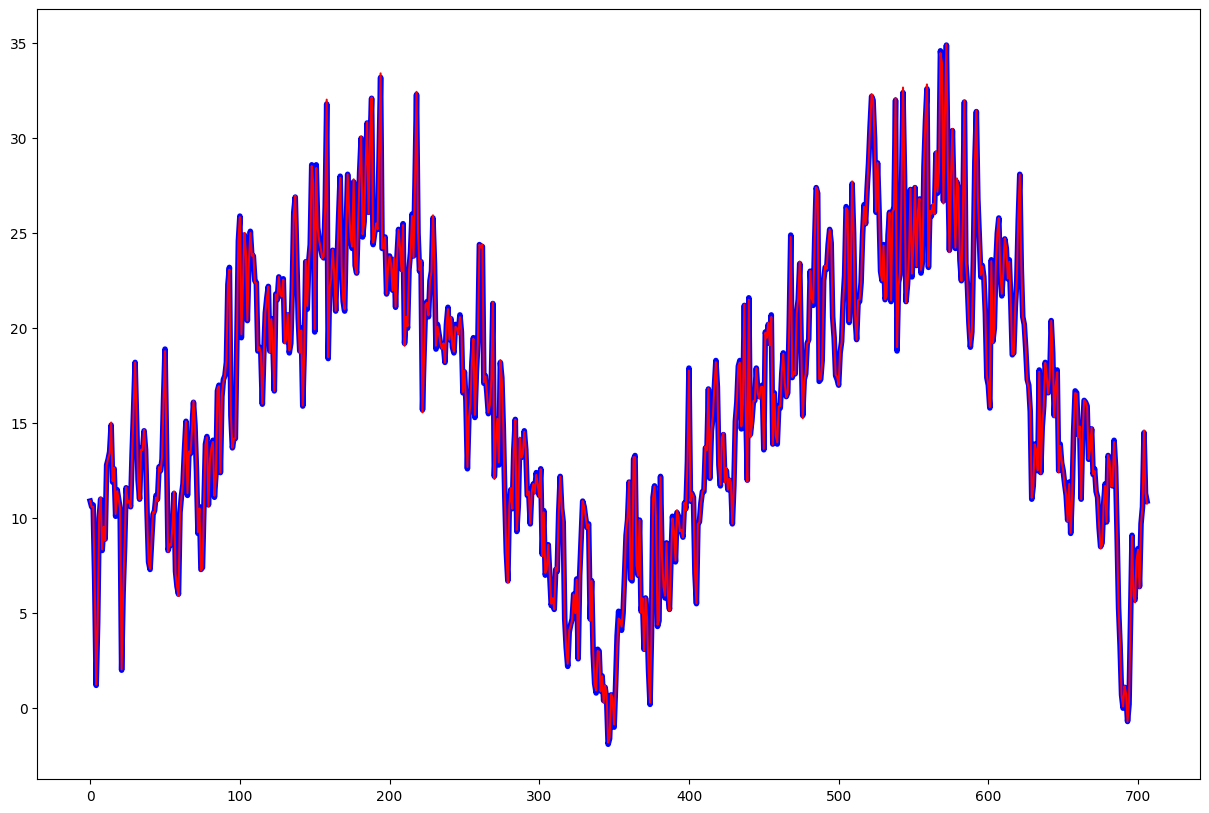

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_2, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [ ]:
# third model
lstm_model_3 = Sequential()

#compile the model
lstm_model_3.add(LSTM(units=32, activation='tanh', input_shape=(X_train_3.shape[1],X_train_3.shape[2])))
lstm_model_3.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model_3.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
lstm_history_3 = lstm_model_3.fit(X_train_3, y_train_3, validation_data=(X_val_3, y_val_3), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
89/89 [==============================] - 3s 14ms/step - loss: 222.0002 - val_loss: 135.1038
Epoch 2/500
89/89 [==============================] - 1s 7ms/step - loss: 98.4966 - val_loss: 71.4321
Epoch 3/500
89/89 [==============================] - 1s 7ms/step - loss: 58.7265 - val_loss: 46.7570
Epoch 4/500
89/89 [==============================] - 1s 7ms/step - loss: 40.3870 - val_loss: 31.9227
Epoch 5/500
89/89 [==============================] - 1s 7ms/step - loss: 28.7168 - val_loss: 22.3268
Epoch 6/500
89/89 [==============================] - 1s 7ms/step - loss: 21.0744 - val_loss: 16.0889
Epoch 7/500
89/89 [==============================] - 1s 6ms/step - loss: 16.0365 - val_loss: 11.9697
Epoch 8/500
89/89 [==============================] - 1s 7ms/step - loss: 12.5076 - val_loss: 9.1414
Epoch 9/500
89/89 [==============================] - 1s 7ms/step - loss: 9.9525 - val_loss: 7.2957
Epoch 10/500
89/89 [==============================] - 1s 6ms/step - loss: 8.0534 - val_loss

In [ ]:
# predict validtion data
y_hat = lstm_model_3.predict(X_val_3)
y_hat.shape

21/21 [==============================] - 0s 3ms/step


(642, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_lstm_3 = mean_squared_error(y_val_3, y_hat).numpy()
mse_lstm_3

0.006691626

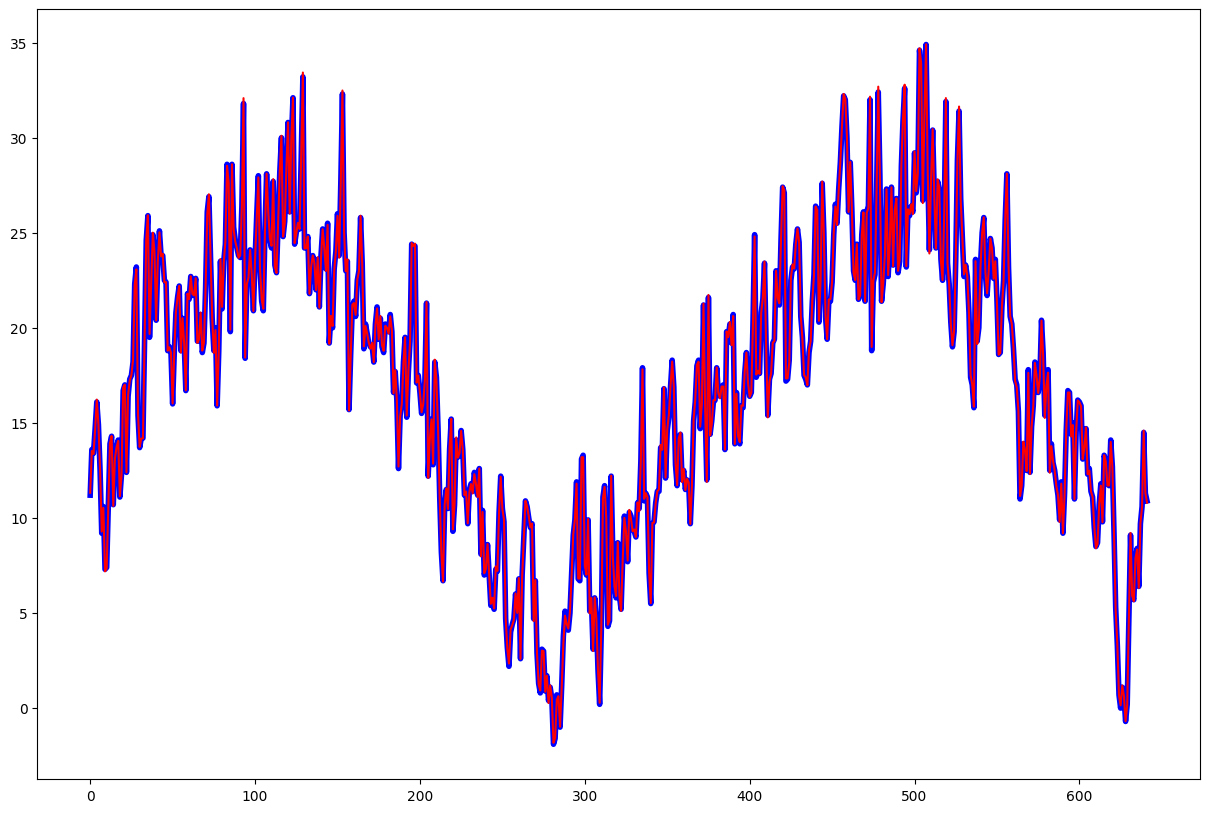

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_3, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

# GRU Models

In [ ]:
# first model
gru_model_1 = Sequential()

#compile the model
gru_model_1.add(GRU(units=32, activation='tanh', input_shape=(X_train_1.shape[1],X_train_1.shape[2])))
gru_model_1.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
gru_model_1.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
gru_history_1 = gru_model_1.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
92/92 [==============================] - 2s 8ms/step - loss: 246.7298 - val_loss: 177.6976
Epoch 2/500
92/92 [==============================] - 0s 4ms/step - loss: 136.9520 - val_loss: 85.7127
Epoch 3/500
92/92 [==============================] - 0s 4ms/step - loss: 71.4857 - val_loss: 51.1904
Epoch 4/500
92/92 [==============================] - 1s 5ms/step - loss: 47.4593 - val_loss: 35.1289
Epoch 5/500
92/92 [==============================] - 1s 6ms/step - loss: 33.1237 - val_loss: 22.7243
Epoch 6/500
92/92 [==============================] - 1s 6ms/step - loss: 23.1649 - val_loss: 16.4847
Epoch 7/500
92/92 [==============================] - 1s 6ms/step - loss: 17.5863 - val_loss: 12.3805
Epoch 8/500
92/92 [==============================] - 1s 6ms/step - loss: 13.7073 - val_loss: 9.5634
Epoch 9/500
92/92 [==============================] - 0s 4ms/step - loss: 11.0526 - val_loss: 7.6467
Epoch 10/500
92/92 [==============================] - 0s 4ms/step - loss: 9.1835 - val_los

In [ ]:
# predict validtion data
y_hat = gru_model_1.predict(X_val_1)
y_hat.shape

23/23 [==============================] - 0s 2ms/step


(731, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_gru_1 = mean_squared_error(y_val_1, y_hat).numpy()
mse_gru_1

0.005317822

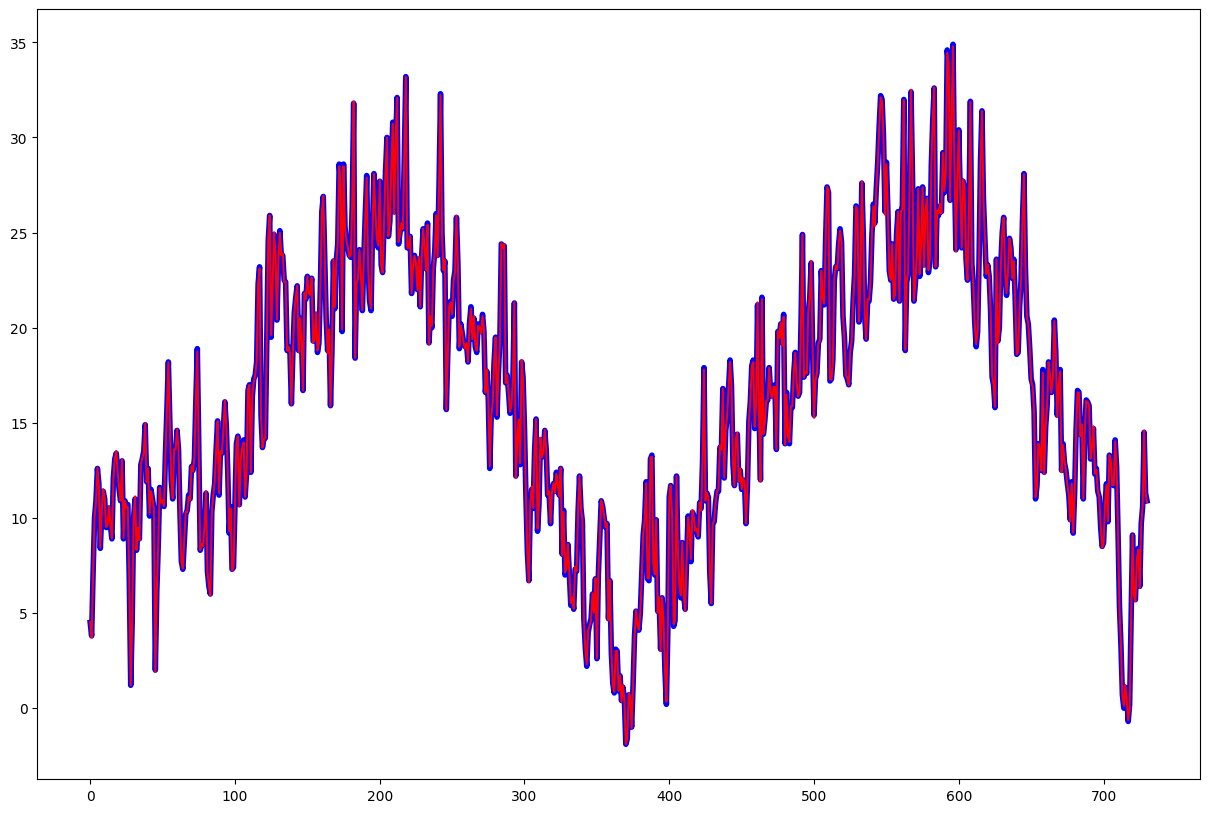

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_1, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [ ]:
# second model
gru_model_2 = Sequential()

#compile the model
gru_model_2.add(GRU(units=32, activation='tanh', input_shape=(X_train_2.shape[1],X_train_2.shape[2])))
gru_model_2.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
gru_model_2.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
gru_history_2 = gru_model_2.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
91/91 [==============================] - 2s 10ms/step - loss: 231.5584 - val_loss: 152.8374
Epoch 2/500
91/91 [==============================] - 0s 5ms/step - loss: 129.9543 - val_loss: 101.8520
Epoch 3/500
91/91 [==============================] - 0s 5ms/step - loss: 90.3437 - val_loss: 71.3793
Epoch 4/500
91/91 [==============================] - 0s 5ms/step - loss: 64.6921 - val_loss: 50.6538
Epoch 5/500
91/91 [==============================] - 1s 6ms/step - loss: 46.7657 - val_loss: 36.0761
Epoch 6/500
91/91 [==============================] - 1s 8ms/step - loss: 34.2252 - val_loss: 25.8266
Epoch 7/500
91/91 [==============================] - 1s 8ms/step - loss: 25.4679 - val_loss: 18.8214
Epoch 8/500
91/91 [==============================] - 1s 8ms/step - loss: 19.2940 - val_loss: 13.8842
Epoch 9/500
91/91 [==============================] - 0s 5ms/step - loss: 14.8724 - val_loss: 10.3948
Epoch 10/500
91/91 [==============================] - 0s 5ms/step - loss: 11.6569 - va

In [ ]:
# predict validtion data
y_hat = gru_model_2.predict(X_val_2)
y_hat.shape

23/23 [==============================] - 0s 2ms/step


(707, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_gru_2 = mean_squared_error(y_val_2, y_hat).numpy()
mse_gru_2

0.0059735584

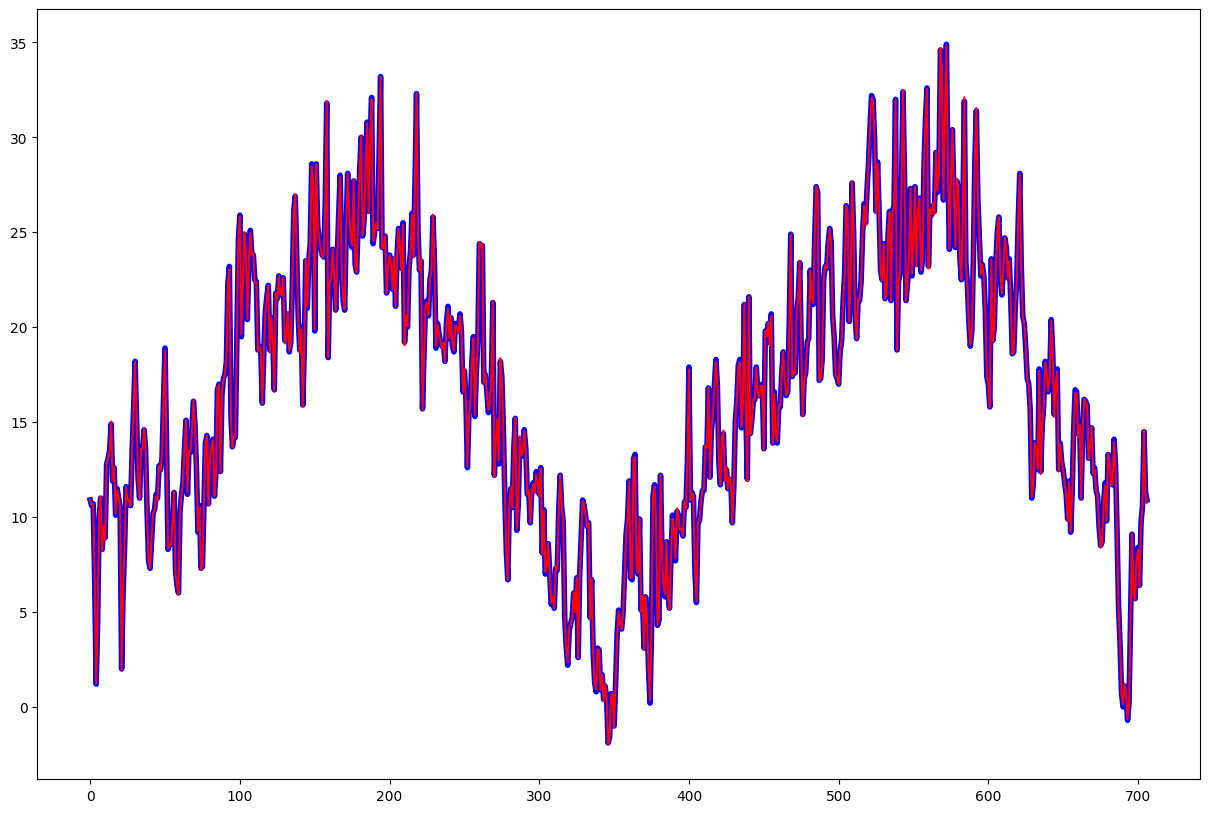

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_2, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

In [ ]:
# third model
gru_model_3 = Sequential()

#compile the model
gru_model_3.add(GRU(units=32, activation='tanh', input_shape=(X_train_3.shape[1],X_train_3.shape[2])))
gru_model_3.add(Dense(units=1))

#compile the model
optimizer = Adam(learning_rate=0.001)
gru_model_3.compile(optimizer=optimizer, loss='mean_squared_error')

# fit the model
gru_history_3 = gru_model_3.fit(X_train_3, y_train_3, validation_data=(X_val_3, y_val_3), epochs=500, batch_size=32, callbacks=[es_callback])

Epoch 1/500
89/89 [==============================] - 3s 12ms/step - loss: 185.4663 - val_loss: 128.9002
Epoch 2/500
89/89 [==============================] - 1s 7ms/step - loss: 104.5163 - val_loss: 87.4051
Epoch 3/500
89/89 [==============================] - 1s 10ms/step - loss: 72.8694 - val_loss: 60.5269
Epoch 4/500
89/89 [==============================] - 1s 10ms/step - loss: 51.6292 - val_loss: 42.1982
Epoch 5/500
89/89 [==============================] - 1s 10ms/step - loss: 36.8742 - val_loss: 29.4943
Epoch 6/500
89/89 [==============================] - 1s 7ms/step - loss: 26.7496 - val_loss: 20.9232
Epoch 7/500
89/89 [==============================] - 1s 6ms/step - loss: 19.8005 - val_loss: 15.1681
Epoch 8/500
89/89 [==============================] - 1s 7ms/step - loss: 14.9864 - val_loss: 11.0873
Epoch 9/500
89/89 [==============================] - 1s 7ms/step - loss: 11.5549 - val_loss: 8.2435
Epoch 10/500
89/89 [==============================] - 1s 6ms/step - loss: 9.0896 - va

In [ ]:
# predict validtion data
y_hat = gru_model_3.predict(X_val_3)
y_hat.shape

21/21 [==============================] - 0s 3ms/step


(642, 1)

In [ ]:
# reshape val data and calculate MSE
y_hat = y_hat.reshape(-1)
mse_gru_3 = mean_squared_error(y_val_3, y_hat).numpy()
mse_gru_3

0.0064596003

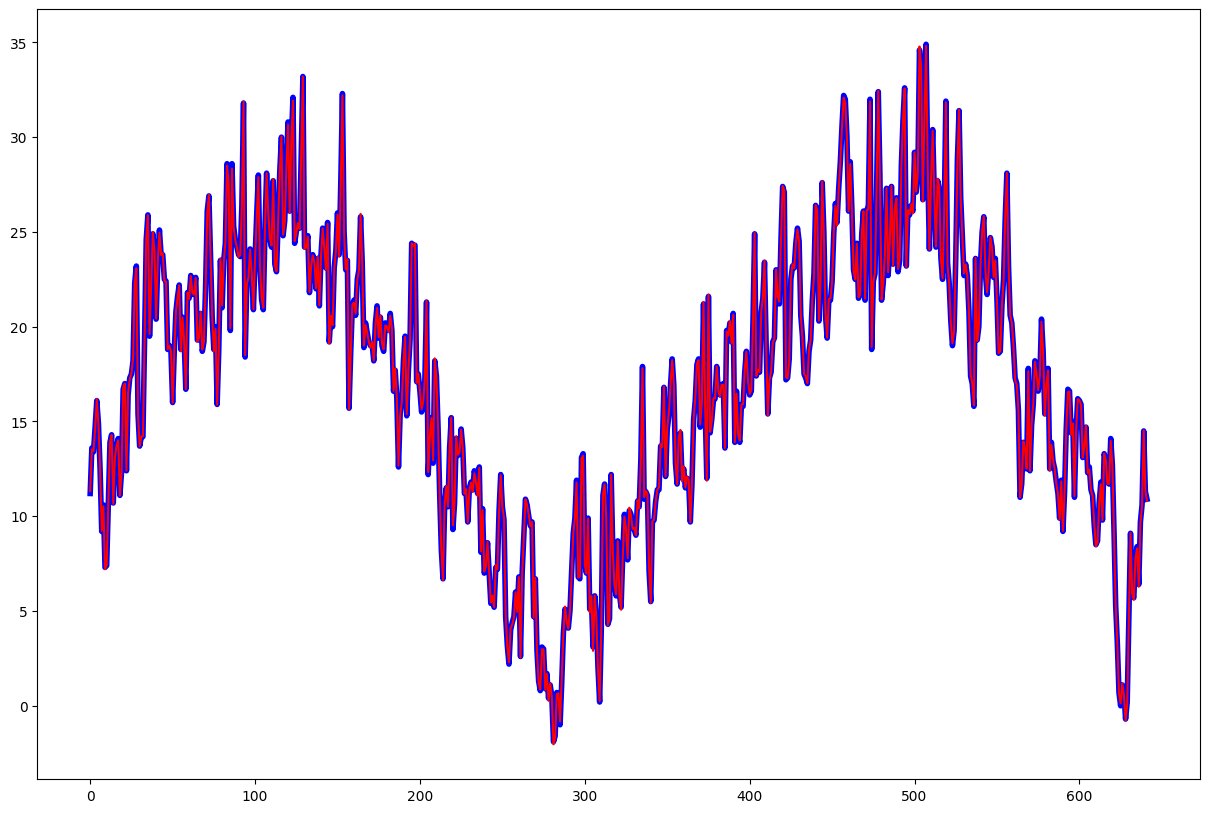

In [ ]:
# plot data
plt.figure(figsize=(15, 10))
plt.plot(y_val_3, c='b',linewidth=4)
plt.plot(y_hat, c='r',linewidth=1.5)
plt.show()

# conclusion

In [ ]:
from tabulate import tabulate

detials = [[1,187,170,141],[25,141,138,101],[90,133,148,100]]
headers = ["Step Size","RNN # of epochs","LSTM # of epochs", "GRU # of epochs"]
print("number of epoch in each step size :\n")
print(tabulate(detials, headers, tablefmt="fancy_grid"))

detials = [[1,mse_rnn_1,mse_lstm_1,mse_gru_1],[25,mse_rnn_2,mse_lstm_2,mse_gru_2],[90,mse_rnn_3,mse_lstm_3,mse_gru_3]]
headers = ["Step Size","RNN val loss","LSTM val loss", "GRU val loss"]
print("validation loss in each step size :\n")
print(tabulate(detials, headers, tablefmt="fancy_grid"))

number of epoch in each step size :

╒═════════════╤═══════════════════╤════════════════════╤═══════════════════╕
│   Step Size │   RNN # of epochs │   LSTM # of epochs │   GRU # of epochs │
╞═════════════╪═══════════════════╪════════════════════╪═══════════════════╡
│           1 │               187 │                170 │               141 │
├─────────────┼───────────────────┼────────────────────┼───────────────────┤
│          25 │               141 │                138 │               101 │
├─────────────┼───────────────────┼────────────────────┼───────────────────┤
│          90 │               133 │                148 │               100 │
╘═════════════╧═══════════════════╧════════════════════╧═══════════════════╛
validation loss in each step size :

╒═════════════╤════════════════╤═════════════════╤════════════════╕
│   Step Size │   RNN val loss │   LSTM val loss │   GRU val loss │
╞═════════════╪════════════════╪═════════════════╪════════════════╡
│           1 │     0.0056477

here in the conclusion information about the number of epochs and validation loss for three different step sizes (1, 25, and 90) for three different types of recurrent neural networks (RNN, LSTM, and GRU). The number of epochs indicates the number of times the model has gone through the training data during the training process. The validation loss indicates how well the model performs on data that it has not seen before (i.e., the validation set).

For a step size of 1, the RNN model was trained for 187 epochs, the LSTM model was trained for 170 epochs, and the GRU model was trained for 141 epochs. The validation loss for the RNN model was 0.00564777, the validation loss for the LSTM model was 0.00588836, and the validation loss for the GRU model was 0.00531782.

For a step size of 25, the RNN model was trained for 141 epochs, the LSTM model was trained for 138 epochs, and the GRU model was trained for 101 epochs. The validation loss for the RNN model was 0.00777171, the validation loss for the LSTM model was 0.0077395, and the validation loss for the GRU model was 0.00597356.

For a step size of 90, the RNN model was trained for 133 epochs, the LSTM model was trained for 148 epochs, and the GRU model was trained for 100 epochs. The validation loss for the RNN model was 0.00751911, the validation loss for the LSTM model was 0.00669163, and the validation loss for the GRU model was 0.0064596.

its noted that the GRU model trained faster with lower loss than the other two models thats because The main difference between RNNs, LSTM, and GRU lies in how they handle information from previous time steps to the current time step. In traditional RNNs, information is passed from one time step to the next through a hidden state, but they suffer from the vanishing gradient problem, which makes it difficult to capture long-term dependencies.

LSTM and GRU were designed to address this issue. LSTM introduces a memory cell that can store information over long periods of time, and it has gates that regulate the flow of information into and out of the cell. GRU also has gates that regulate the flow of information, but it has a simpler architecture than LSTM, with fewer parameters to estimate.

In summary, LSTM and GRU are more advanced versions of RNNs that are better suited for capturing long-term dependencies in sequential data. LSTM has more complex architecture than GRU, which makes it more powerful but also more computationally expensive. GRU, on the other hand, is simpler and faster to train than LSTM but may not be able to capture as much long-term information.